In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [2]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'figure.figsize': (18, 10),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

In [3]:
dfp = pd.read_csv("Population Estimates by State.csv")
def get_pop(state):
    global dpf
    state_map = {'CA': 'California', 'TX': 'Texas', 'OH': 'Ohio', 'WI': 'Wisconsin', 'AZ': 'Arizona',
                 'CO': 'Colorado', 'MI': 'Michigan', 'FL': 'Florida', 'SD': 'South Dakota', 'WY': 'Wyoming',
                 'PA': 'Pennsylvania'}
    if state in state_map:
        return dfp[dfp.States == state_map[state]].iloc[0].Population
    else:
        return 0

In [24]:
#df = pd.read_csv('/Users/dane/odd/data/usafacts.org_covid_data/covid_confirmed_usafacts.csv')
df = pd.read_csv('http://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_confirmed_usafacts.csv')
#df.to_csv('/Users/dane/odd/data/usafacts.org_covid_data/covid_confirmed_usafacts.csv')

# fix county names as they can have trailing spaces
df['County Name'] = df['County Name'].apply(lambda x: x.strip())
df.head(1)

,countyFIPS,County Name,State,StateFIPS,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,...,2021-04-03,2021-04-04,2021-04-05,2021-04-06,2021-04-07,2021-04-08,2021-04-09,2021-04-10,2021-04-11,2021-04-12
0,0,Statewide Unallocated,AL,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
cases = []
def get_county_data(row):
    global cases
    county = row['County Name'].replace(' County','')
    state = row.State
    ident = county + ', ' + state
    
    cases = row[4:]
    cdf = pd.DataFrame({'cases': cases, 'cpd': cases.diff()}).dropna()
    cdf.index.name = ident
    # cdf['day'] = pd.to_datetime(cdf.index, format='%m/%d/%y')
    # 2021-04-14 date format changed
    cdf['day'] = pd.to_datetime(cdf.index, format='%Y-%m-%d')
    cdf['week'] = cdf.day.apply(lambda x: int(x.strftime('%U')))
    return cdf

def get_state_data(df):
    global cases
    cases = df.sum()[4:]
    cdf = pd.DataFrame({'cases': cases, 'cpd': cases.diff()}).dropna()
    cdf['day'] = pd.to_datetime(cdf.index, format='%Y-%m-%d')
    cdf['week'] = cdf.day.apply(lambda x: int(x.strftime('%U')))
    return cdf

In [35]:
def get_county(df, county, state):
    mask1 = df['County Name'] == county
    mask2 = df['State'] == state
    rows = df[mask1 & mask2]
    
    if len(rows) == 1:
        return get_county_data(rows.iloc[0])
    elif len(rows) == 0:
        return 'No matches'
    else:
        
        return [x.State for k, x in rows.iterrows()]

def get_state(df, state):
    mask2 = df['State'] == state
    rows = df[mask2]
    return get_state_data(rows)

In [36]:
cdf

'No matches'

In [37]:
cdf = get_county(df, 'Santa Cruz County', 'CA')
cdf

,cases,cpd,day,week
"Santa Cruz, CA",,,,
2020-01-23,0,0,2020-01-23,3
2020-01-24,0,0,2020-01-24,3
2020-01-25,0,0,2020-01-25,3
2020-01-26,0,0,2020-01-26,4
2020-01-27,0,0,2020-01-27,4
...,...,...,...,...
2021-04-08,15295,0,2021-04-08,14
2021-04-09,15296,1,2021-04-09,14
2021-04-10,15331,35,2021-04-10,14


In [44]:
def plot_cpd(d):
    fig = plt.gcf()
    d = d[d.index > '2021-01-01']
    fig.set_size_inches(18,10)
    weekly = d.groupby('week').cpd.sum()
    #ax = weekly.plot(kind='bar')
    ax = weekly[:-1].plot(kind='bar')  # skip last partial week
    plt.title(d.index.name, fontsize=20)
    ax.tick_params(axis="x", labelsize=20)
    ax.tick_params(axis="y", labelsize=20)
    #ax.text(0,100,'43=November 2', fontsize=15)
    ax.axvline(x=40, c="black")
    plt.plot()
    m1 = weekly.iloc[-3]  # -3 because current week is partial
    m2 = weekly.iloc[-2]
    gain = 100 * ((m2 / m1) - 1)
    print(f'Last Week {m1} -> {m2} ({gain:.1f}%)')
    print(f'Population: {get_pop(d.index.name)}')

Last Week 57 -> 36 (-36.8%)
Population: 0


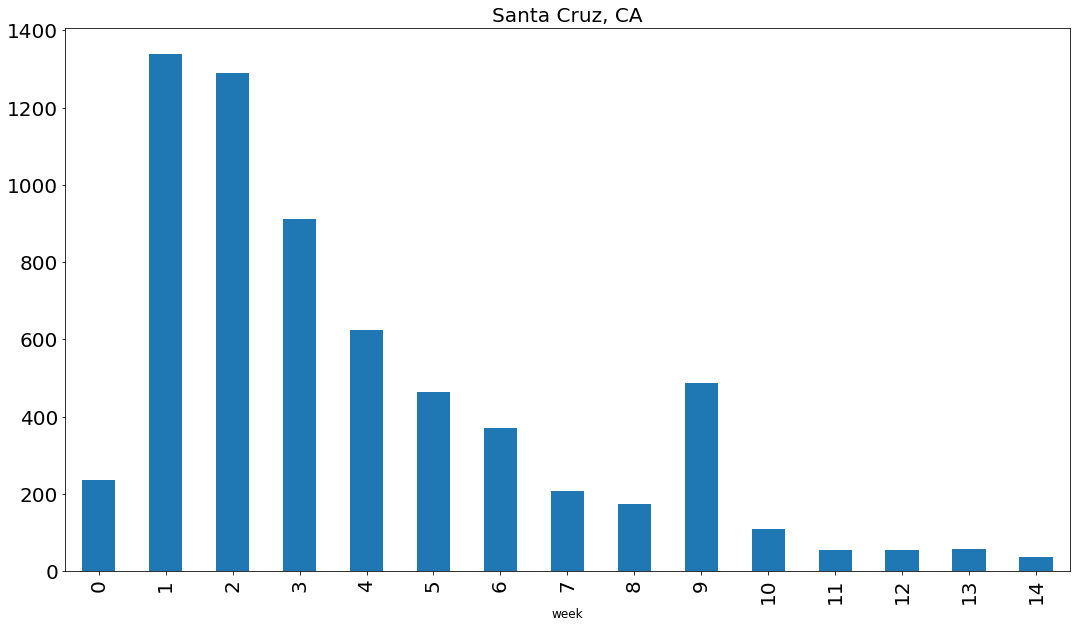

In [45]:
plot_cpd(cdf)

Last Week 545 -> 972 (78.3%)
Population: 0


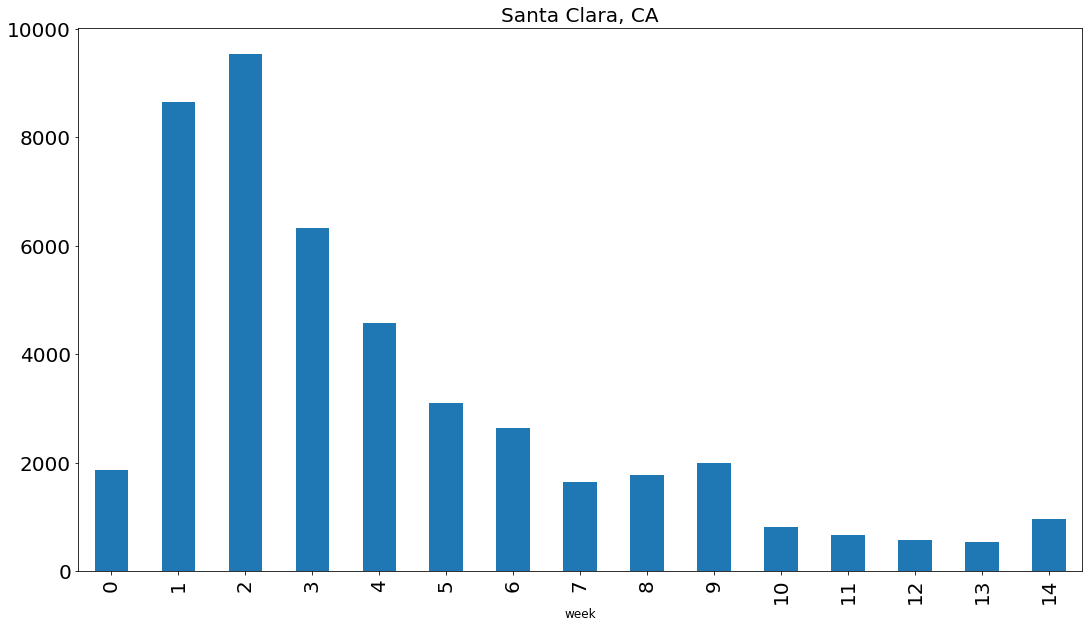

In [46]:
scdf = get_county(df, 'Santa Clara County', 'CA')
plot_cpd(scdf)

Last Week 1785 -> 3400 (90.5%)
Population: 0


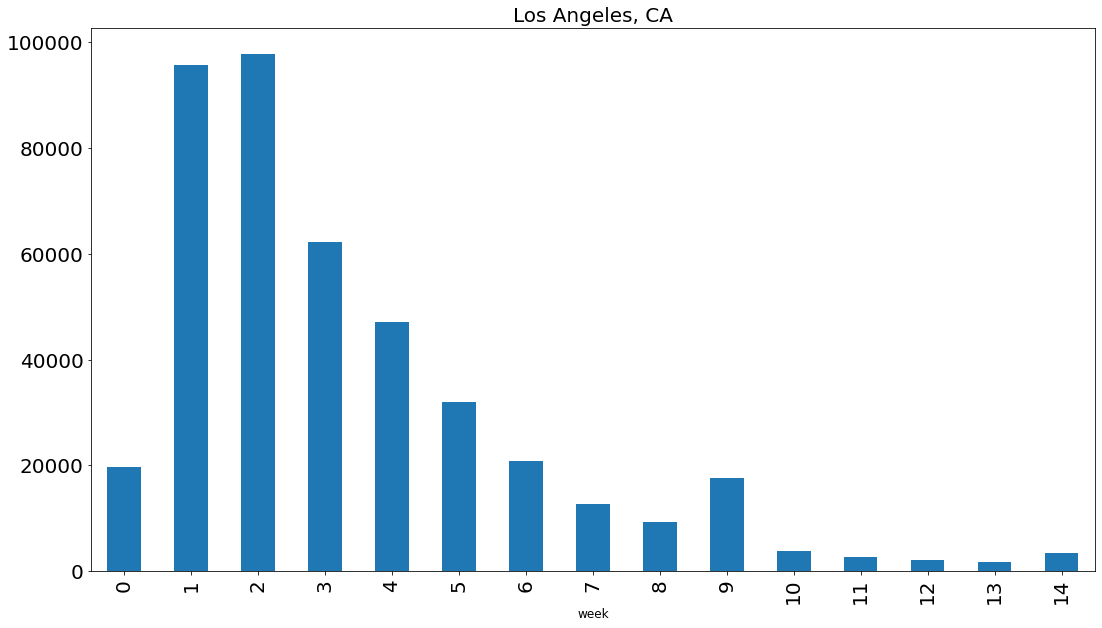

In [47]:
scdf = get_county(df, 'Los Angeles County', 'CA')
plot_cpd(scdf)

Last Week 1560 -> 1661 (6.5%)
Population: 0


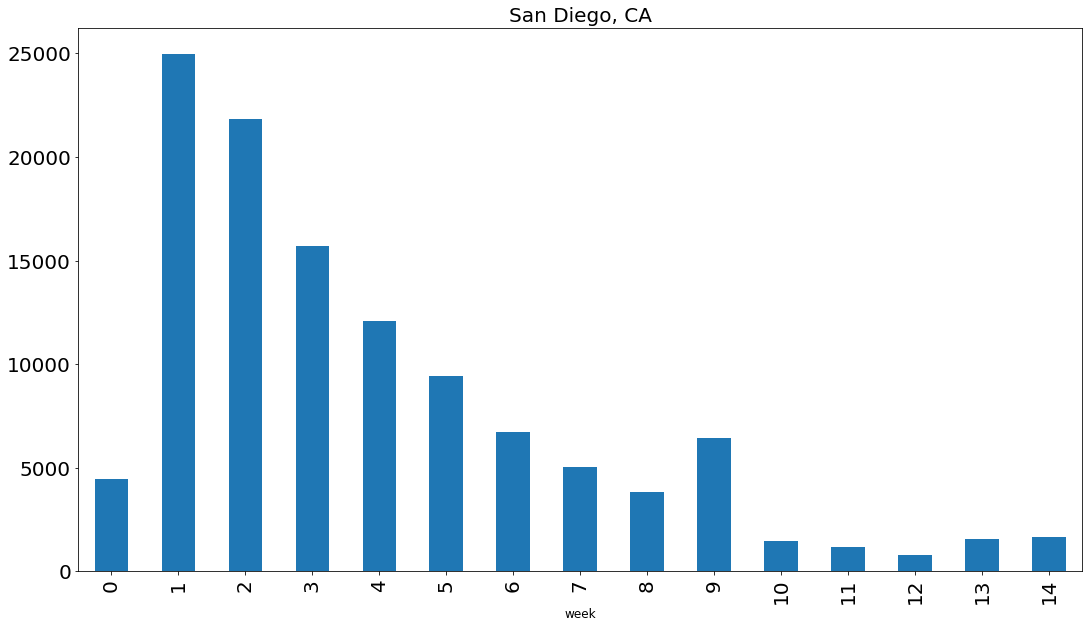

In [48]:
scdf = get_county(df, 'San Diego County', 'CA')
plot_cpd(scdf)

Last Week 454 -> 544 (19.8%)
Population: 0


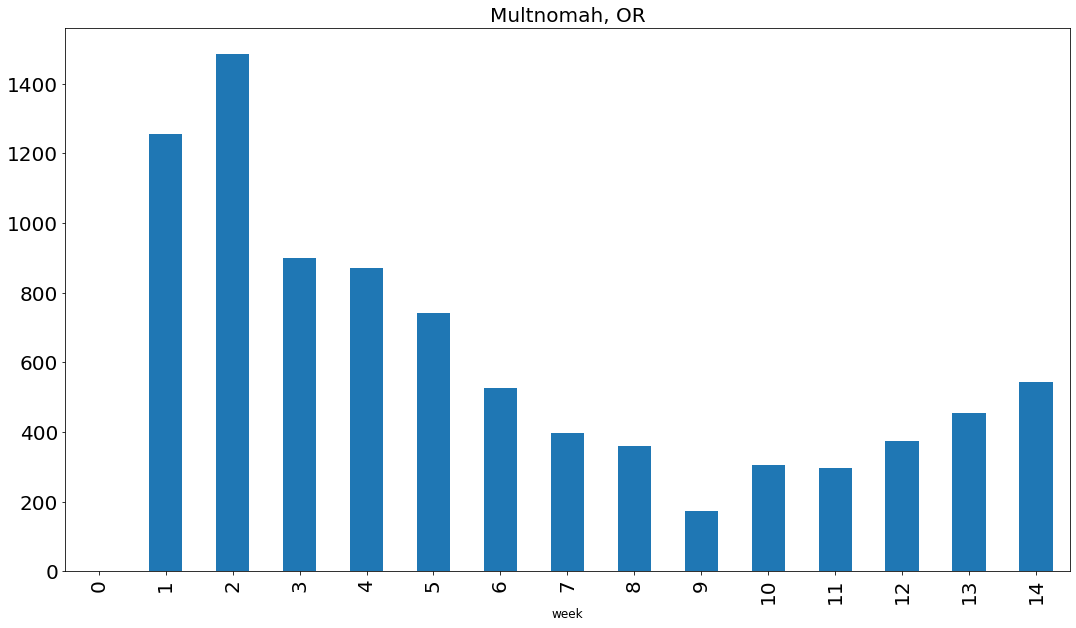

In [49]:
scdf = get_county(df, 'Multnomah County', 'OR')
plot_cpd(scdf)

Last Week 4436 -> 5233 (18.0%)
Population: 7,278,717


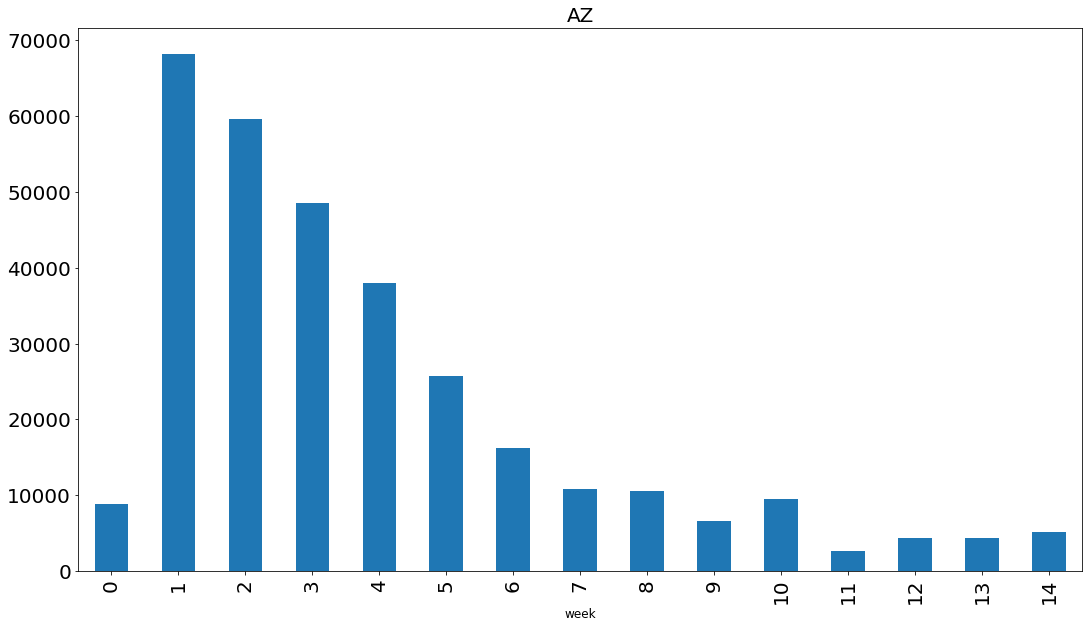

In [50]:
cadf = get_state(df, 'AZ')
cadf.index.name = 'AZ'
plot_cpd(cadf)

Last Week 13475 -> 17273 (28.2%)
Population: 39,512,223


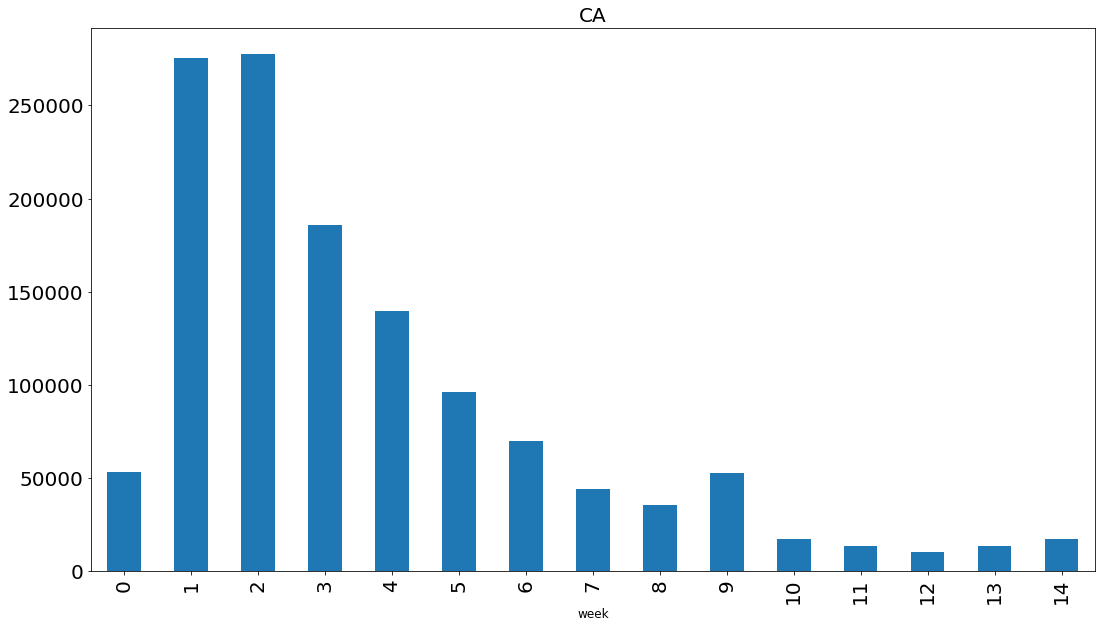

In [51]:
cadf = get_state(df, 'CA')
cadf.index.name = 'CA'
plot_cpd(cadf)

Last Week 9306 -> 10537 (13.2%)
Population: 5,758,736


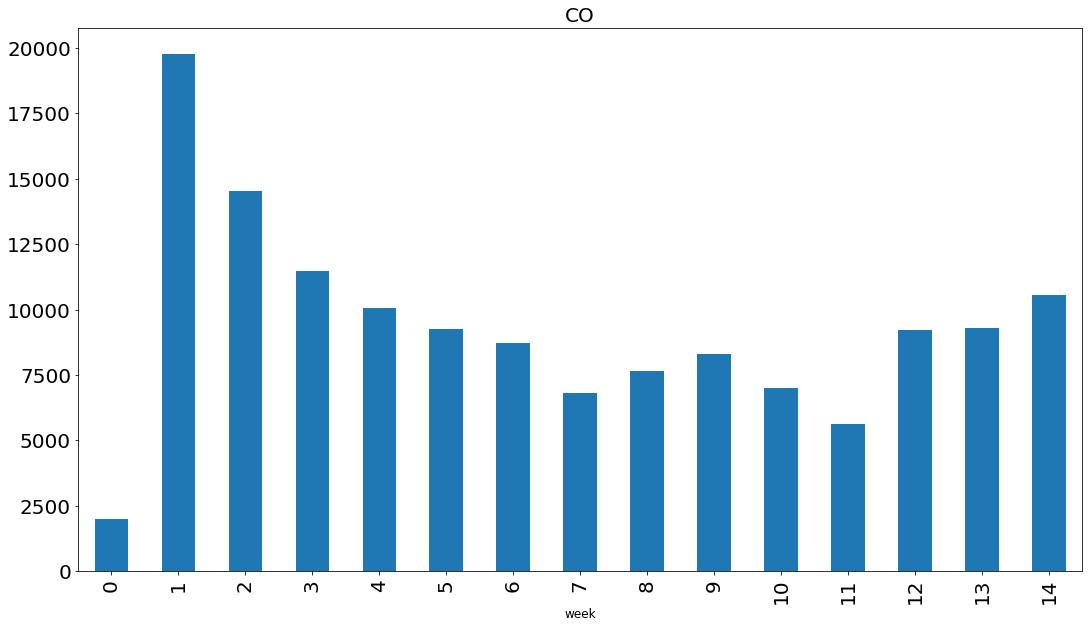

In [52]:
cadf = get_state(df, 'CO')
cadf.index.name = 'CO'
plot_cpd(cadf)

Last Week 38024 -> 41625 (9.5%)
Population: 21,477,737


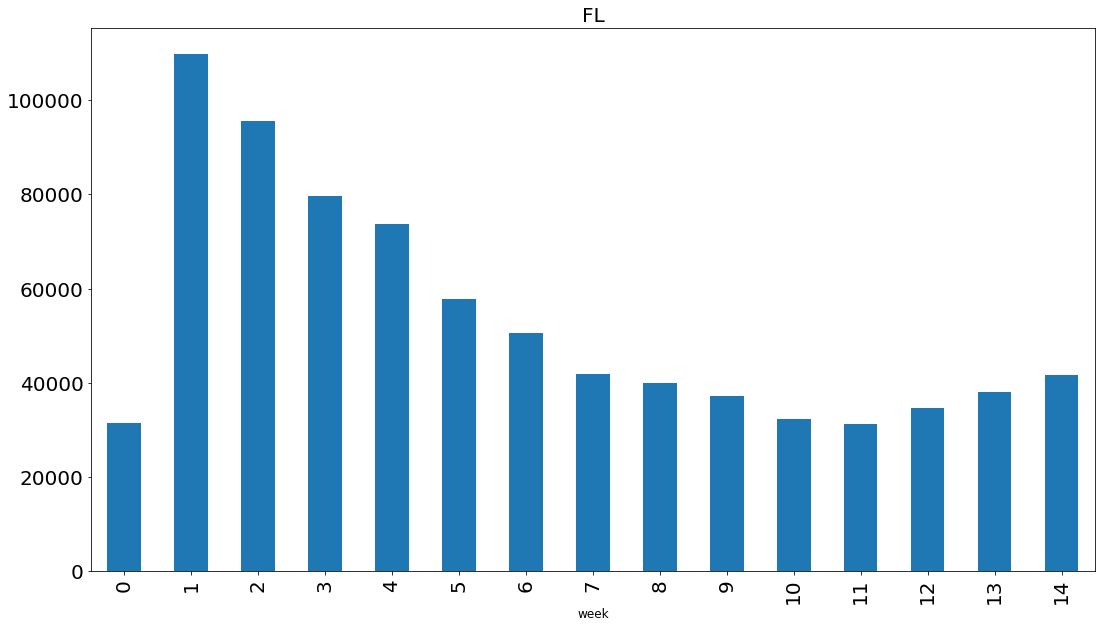

In [53]:
cadf = get_state(df, 'FL')
cadf.index.name = 'FL'
plot_cpd(cadf)

Last Week 6184 -> 6226 (0.7%)
Population: 0


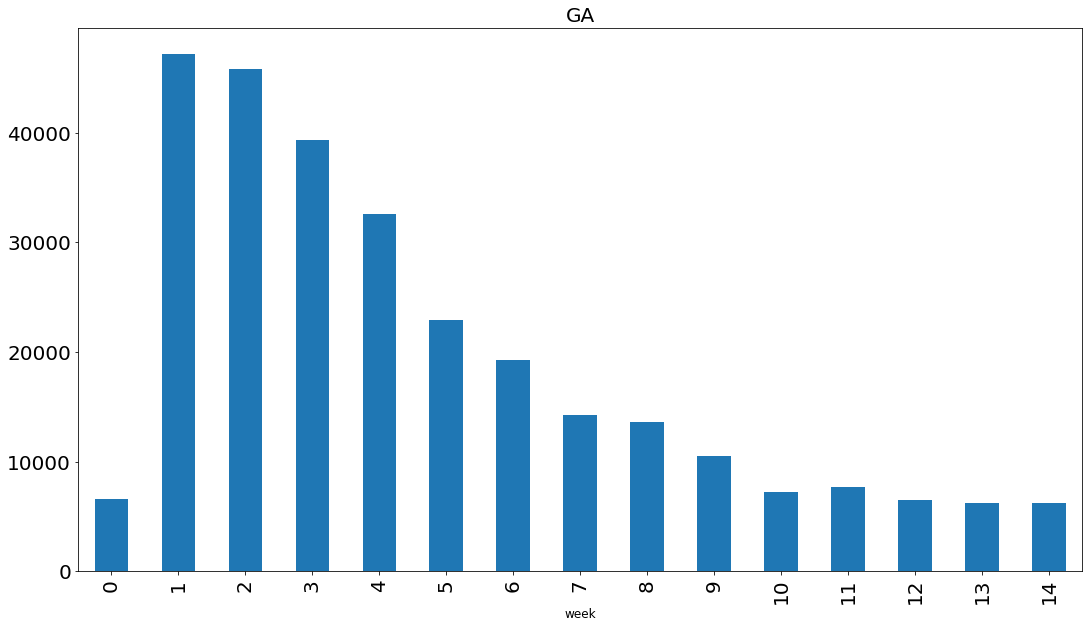

In [54]:
cadf = get_state(df, 'GA')
cadf.index.name = 'GA'
plot_cpd(cadf)

Last Week 6901 -> 7557 (9.5%)
Population: 0


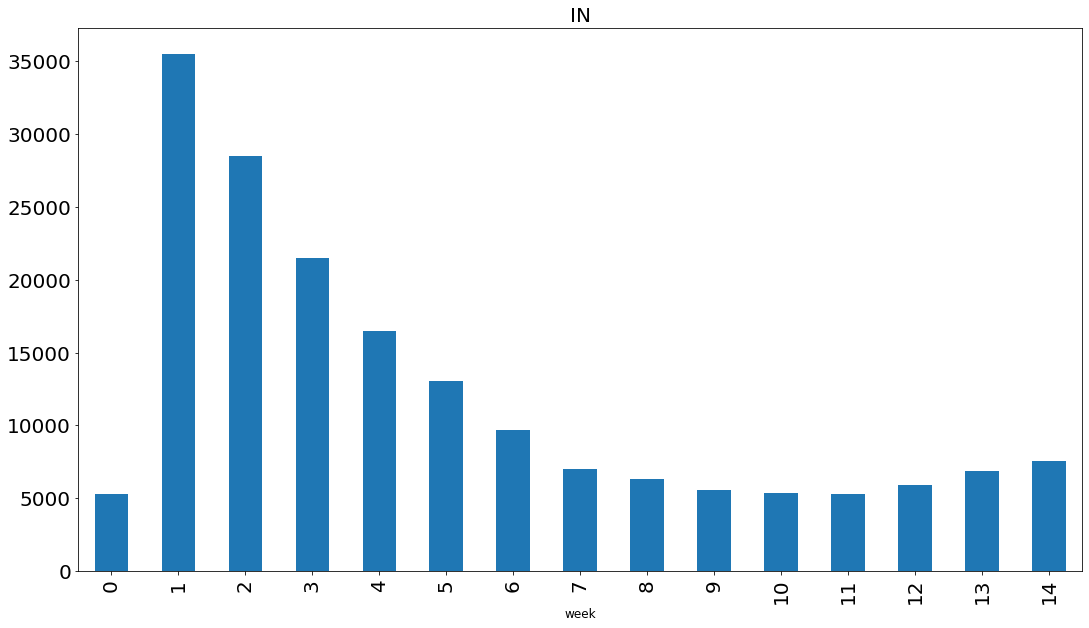

In [55]:
cadf = get_state(df, 'IN')
cadf.index.name = 'IN'
plot_cpd(cadf)

Last Week 18607 -> 22642 (21.7%)
Population: 0


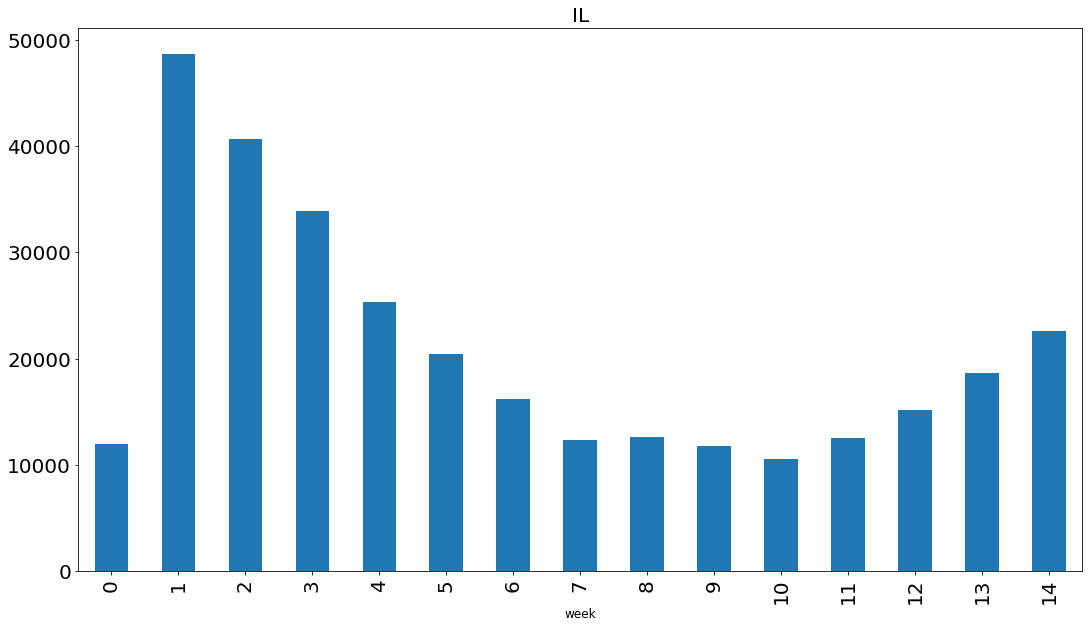

In [56]:
cadf = get_state(df, 'IL')
cadf.index.name = 'IL'
plot_cpd(cadf)

Last Week 4923 -> 3614 (-26.6%)
Population: 0


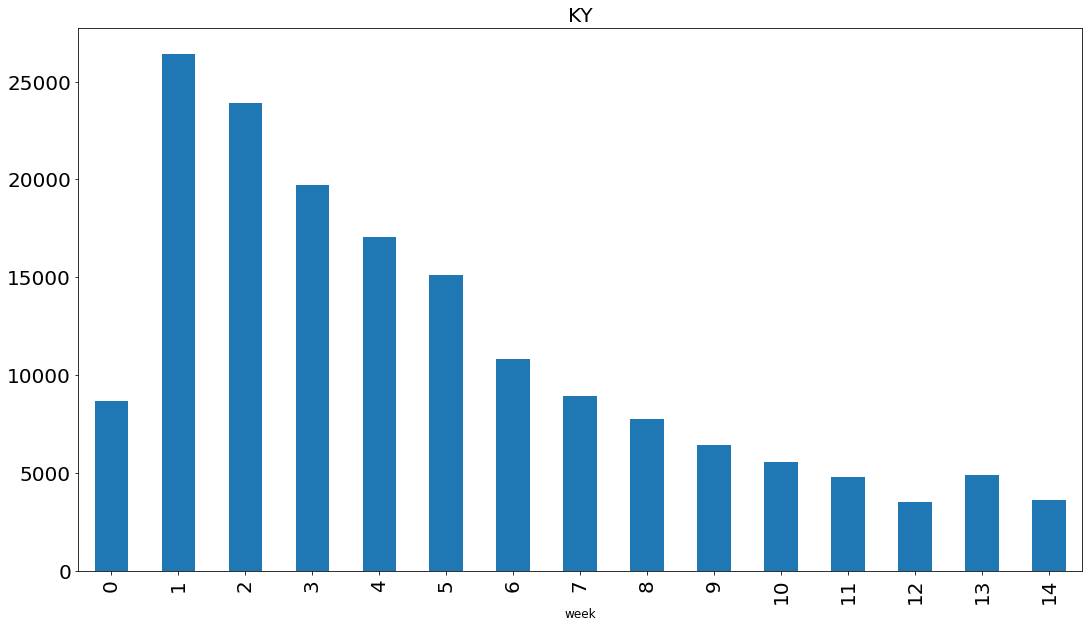

In [57]:
cadf = get_state(df, 'KY')
cadf.index.name = 'KY'
plot_cpd(cadf)

Last Week 45194 -> 51510 (14.0%)
Population: 9,986,857


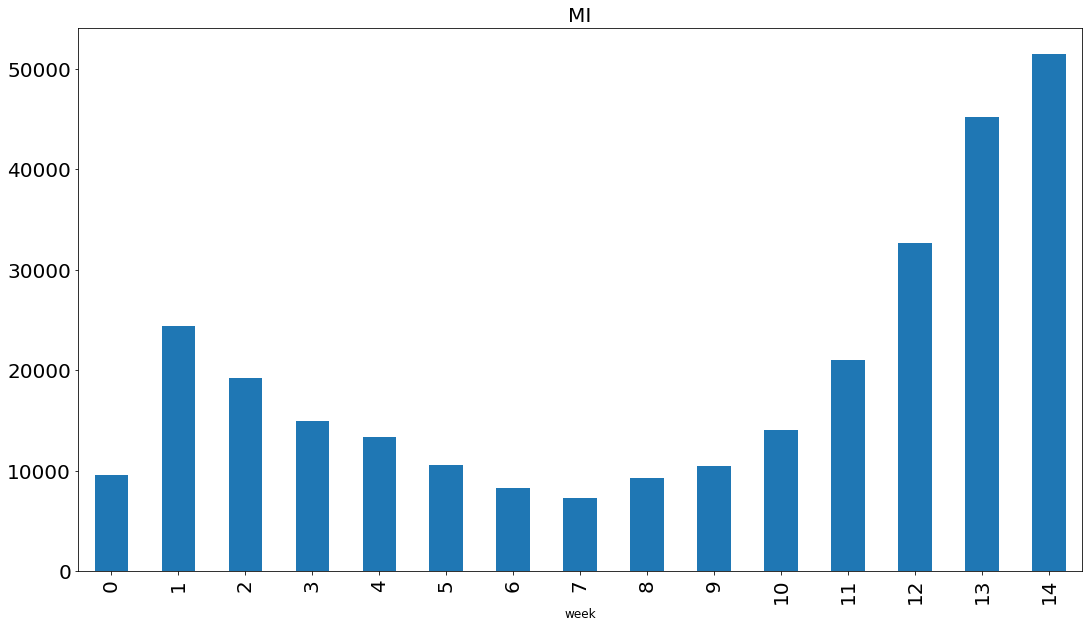

In [58]:
cadf = get_state(df, 'MI')
cadf.index.name = 'MI'
plot_cpd(cadf)

Last Week 12433 -> 14010 (12.7%)
Population: 0


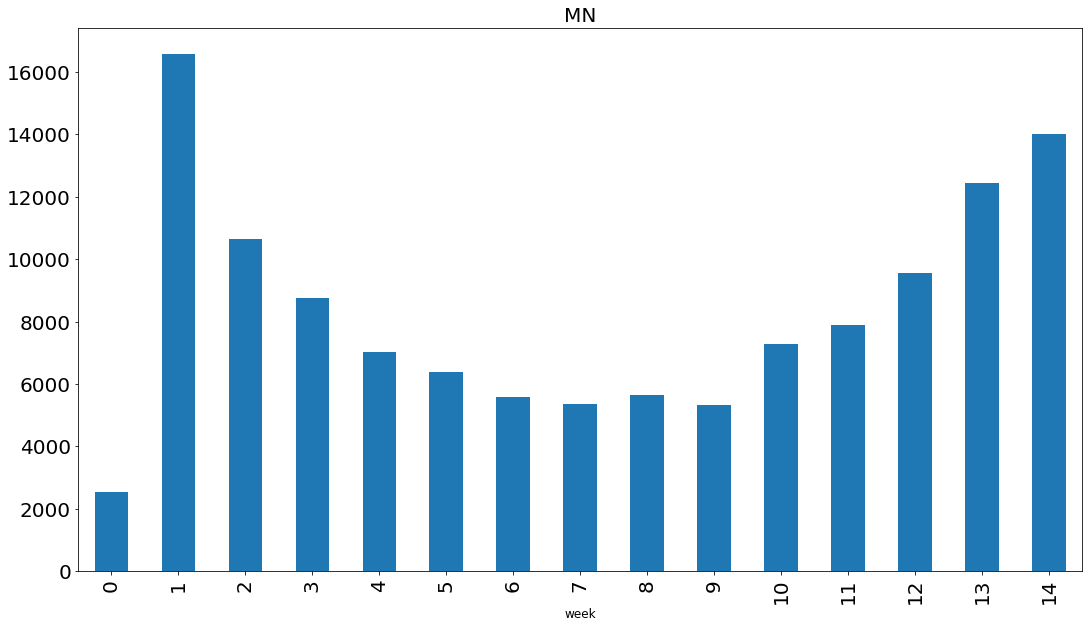

In [59]:
cadf = get_state(df, 'MN')
cadf.index.name = 'MN'
plot_cpd(cadf)

Last Week 56408 -> 51687 (-8.4%)
Population: 0


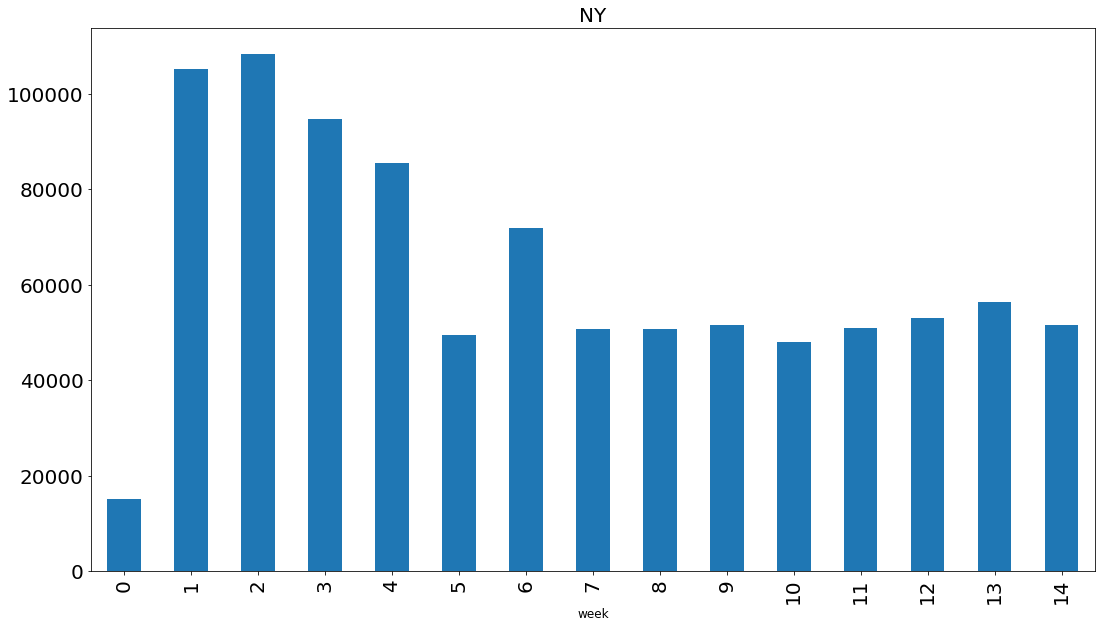

In [60]:
cadf = get_state(df, 'NY')
cadf.index.name = 'NY'
plot_cpd(cadf)

Last Week 15094 -> 13618 (-9.8%)
Population: 11,689,100


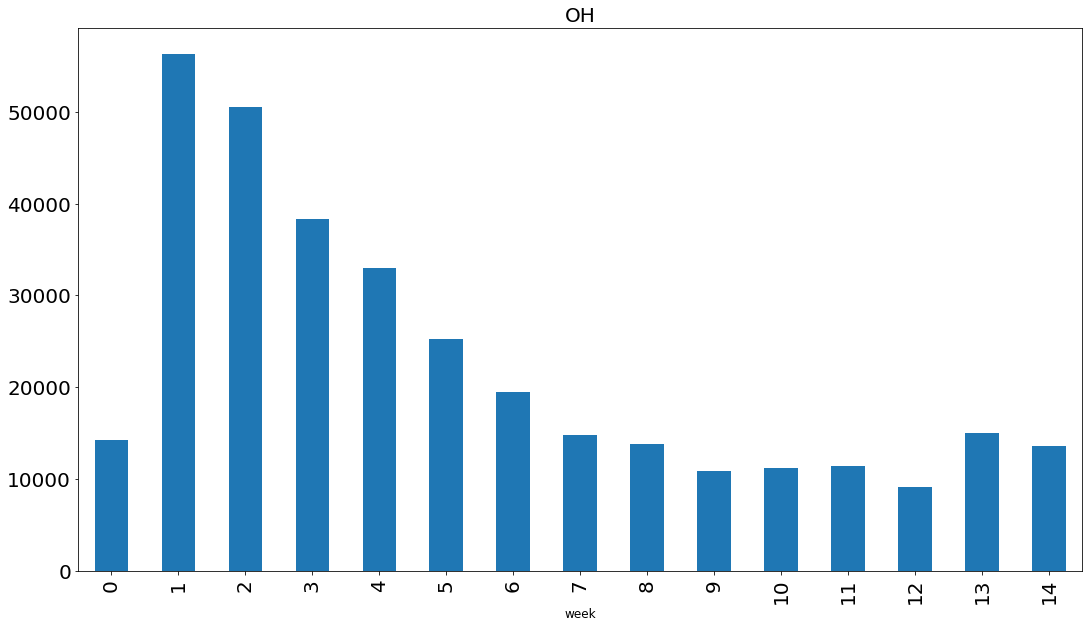

In [61]:
cadf = get_state(df, 'OH')
cadf.index.name = 'OH'
plot_cpd(cadf)

Last Week 29185 -> 30224 (3.6%)
Population: 12,801,989


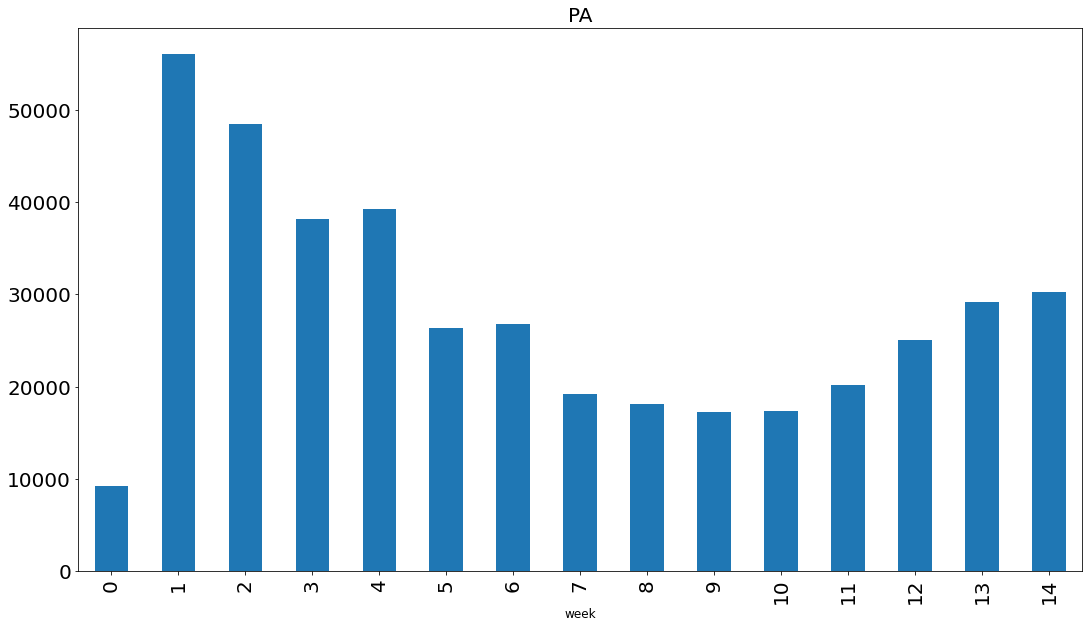

In [62]:
cadf = get_state(df, 'PA')
cadf.index.name = 'PA'
plot_cpd(cadf)

Last Week 1003 -> 1334 (33.0%)
Population: 884,659


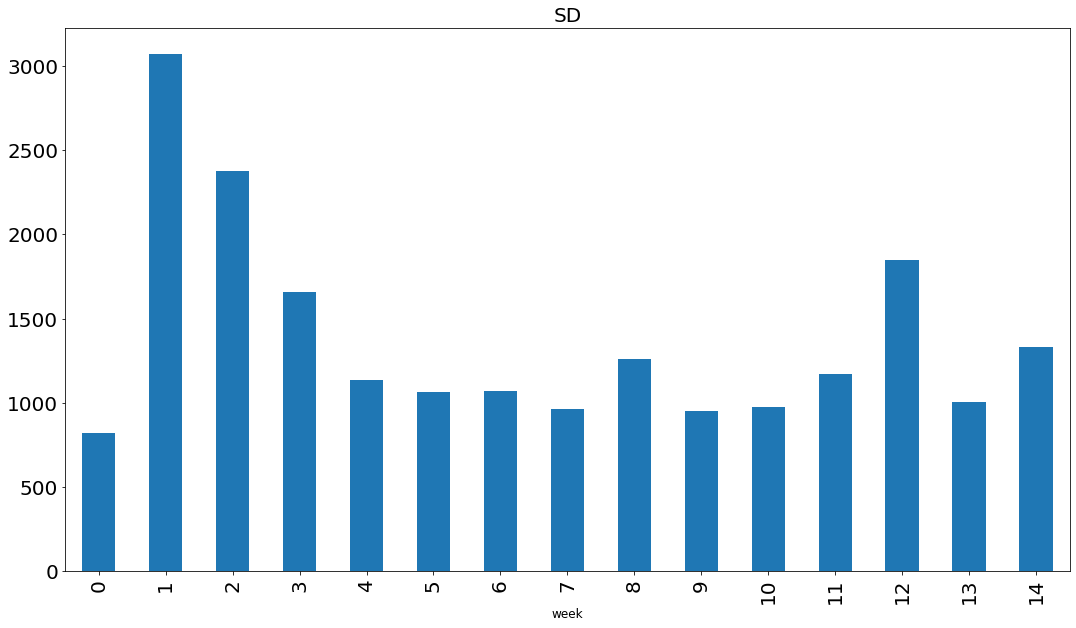

In [63]:
cadf = get_state(df, 'SD')
cadf.index.name = 'SD'
plot_cpd(cadf)

Last Week 20701 -> 24287 (17.3%)
Population: 28,995,881


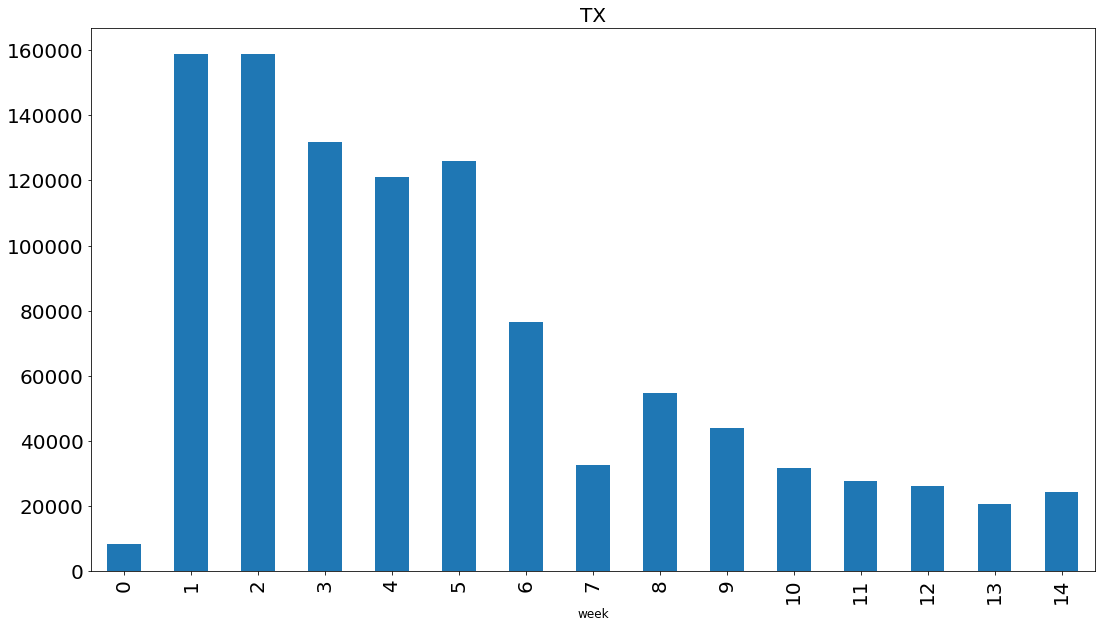

In [64]:
cadf = get_state(df, 'TX')
cadf.index.name = 'TX'
plot_cpd(cadf)

Last Week 4923 -> 6311 (28.2%)
Population: 5,822,434


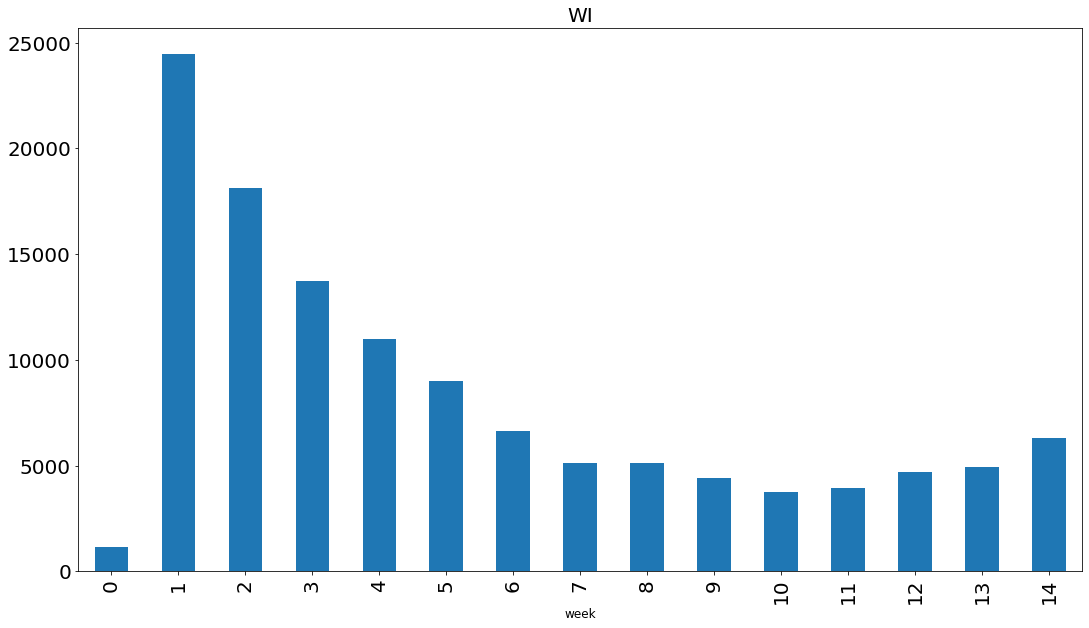

In [65]:
cadf = get_state(df, 'WI')
cadf.index.name = 'WI'
plot_cpd(cadf)

Last Week 405 -> 421 (4.0%)
Population: 578,759


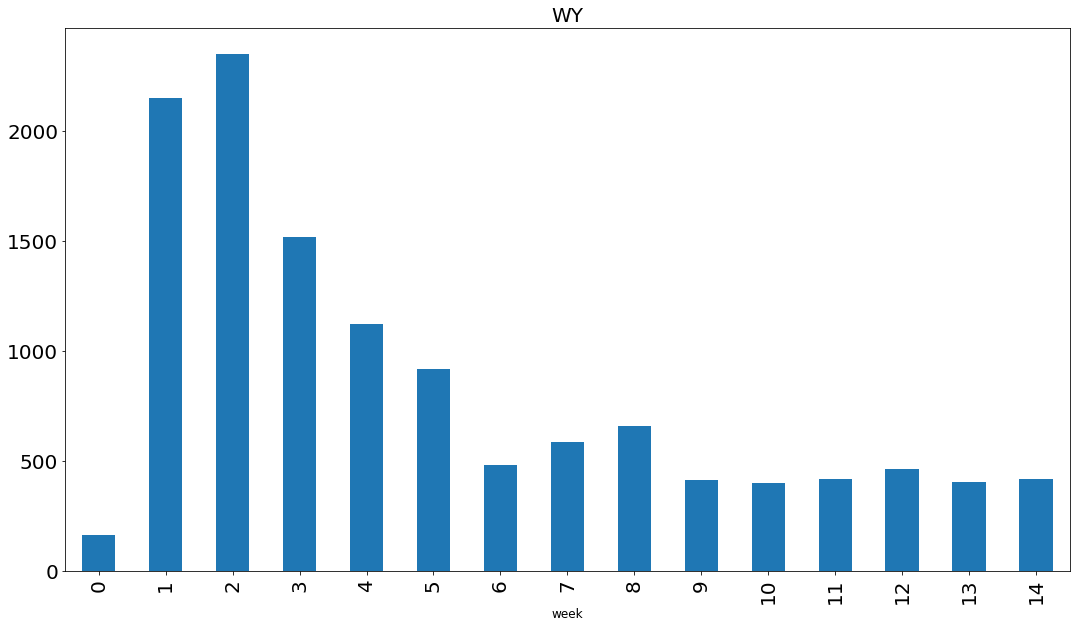

In [66]:
cadf = get_state(df, 'WY')
cadf.index.name = 'WY'
plot_cpd(cadf)